# Efficiency of different stimulus ensembles for systems identification

In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotnine
import seaborn as sns

sns.set(style="darkgrid")


class LNP:
    """A simple LNP model neuron."""
    def __init__(self):
        rg = np.arange(-31.5, 32.5)
        self.w = np.cos(rg / 20.0 * 2 * np.pi) * np.exp(-rg ** 2 / 2 / 10 ** 2)
        self.w /= 4
        self.input_size = len(self.w)
        self.rate_multiplier = 1
        
    def forward(self, X):
        """The nonlinearity is $\log(1 + \exp(x))$"""
        return np.random.poisson(self.rate_multiplier * np.log(1 + np.exp(X.dot(self.w) - .5)))

Text(0.5, 1.0, 'Model weights')

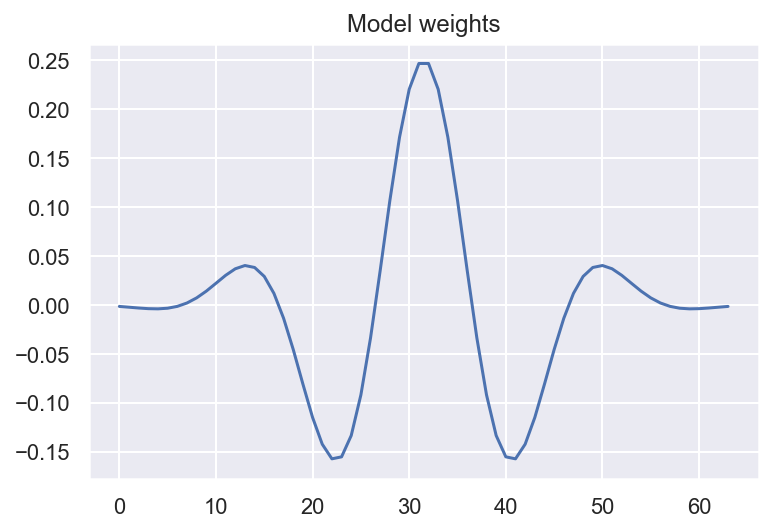

In [2]:
N = 10000
model = LNP()

plt.plot(model.w)
plt.title("Model weights")

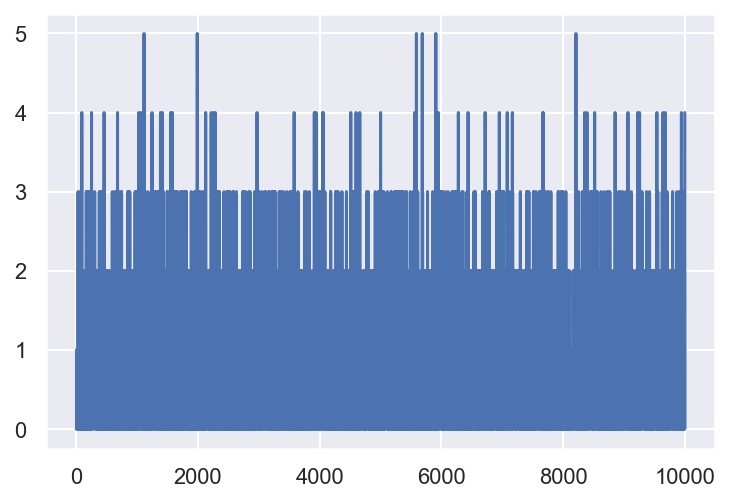

In [3]:
X = np.random.randn(N, model.input_size)
Y = model.forward(X)

# Measure the convergence of the model as a function of N
plt.plot(Y)

Calculate estimates of the weights using reverse correlation. This is given by:

$$\frac{1}{N} X^T$$

We use a clever way to perform this calculation in a cumulative way so that we can get estimates for number of stimuli.

In [4]:
def estimate_w_hat(X, Y):
    N = X.shape[0]
    # remove the mean.
    estimates = np.cumsum(X * (Y.reshape((-1, 1))), axis=0)
    w_hat = 1 / np.arange(1, N + 1).reshape((-1, 1)) * estimates
    return w_hat

def calculate_rho(w_hats, w):
    rhos = w_hats.dot(w) / np.sqrt((w_hats ** 2).sum(1) * (w ** 2).sum())
    assert rhos.shape == w_hats.shape[:1]
    return rhos

/home/pmin/miniconda3/envs/brian-notebooks/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Text(0.5, 1.0, 'correlation between estimated weights and true weights')

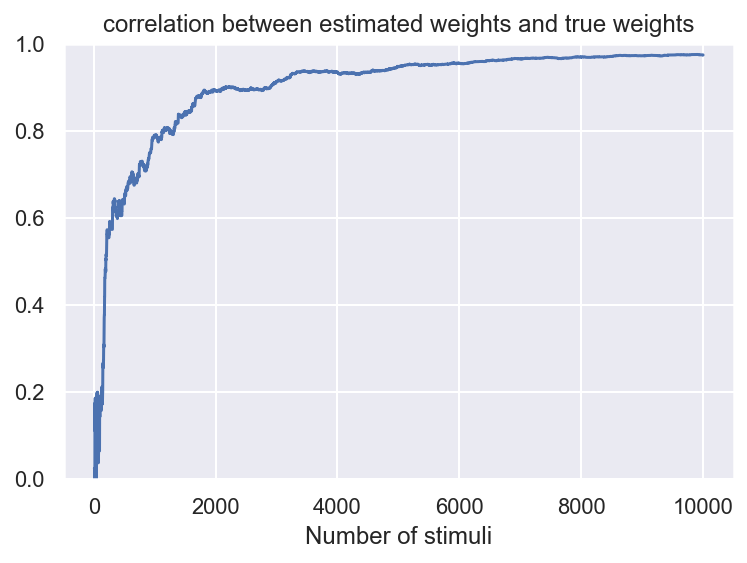

In [5]:
w_hat = estimate_w_hat(X, Y)
rho = calculate_rho(w_hat, model.w)

plt.plot(np.arange(1, N+1), rho)
plt.xlabel("Number of stimuli")
plt.ylim((0, 1))
plt.title("correlation between estimated weights and true weights")

Now do the same but with antithetical sampling.

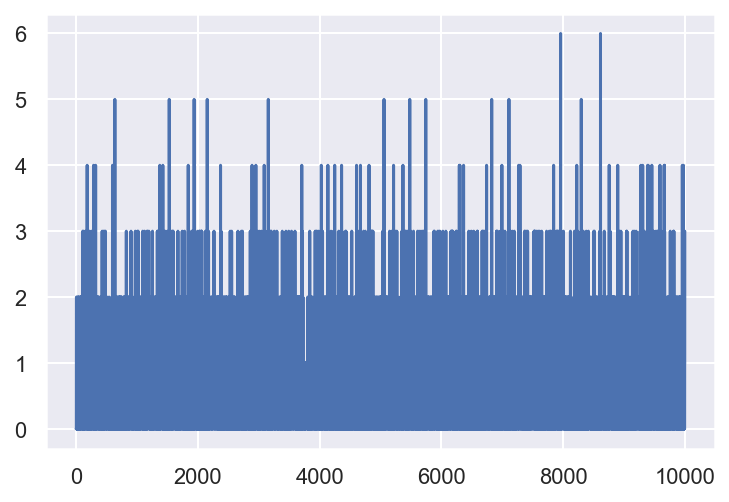

In [6]:
rg = np.floor(np.arange(N) / 2.0).astype(np.int)
alternating_sign = 2 * ((np.arange(N) % 2) - .5)
Xs = alternating_sign.reshape((-1, 1)) * X[rg, :]
Y = model.forward(Xs)

# Measure the convergence of the model as a function of N
plt.plot(Y)

np.testing.assert_allclose(Xs[0, :], -Xs[1, :])


/home/pmin/miniconda3/envs/brian-notebooks/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Text(0.5, 1.0, 'Correlation between estimated weights and true weights, antithetical sampling')

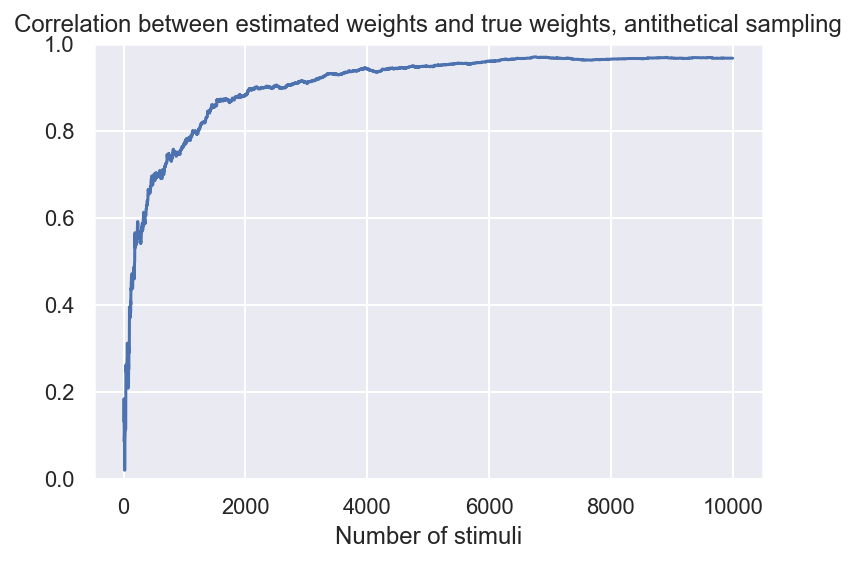

In [7]:
w_hat = estimate_w_hat(Xs, Y)
rho_p = calculate_rho(w_hat, model.w)

plt.plot(np.arange(1, N+1), rho_p)
plt.xlabel("Number of stimuli")
plt.ylim((0, 1))
plt.title("Correlation between estimated weights and true weights, antithetical sampling")

Text(0.5, 1.0, 'Correlation between estimated weights and true weights')

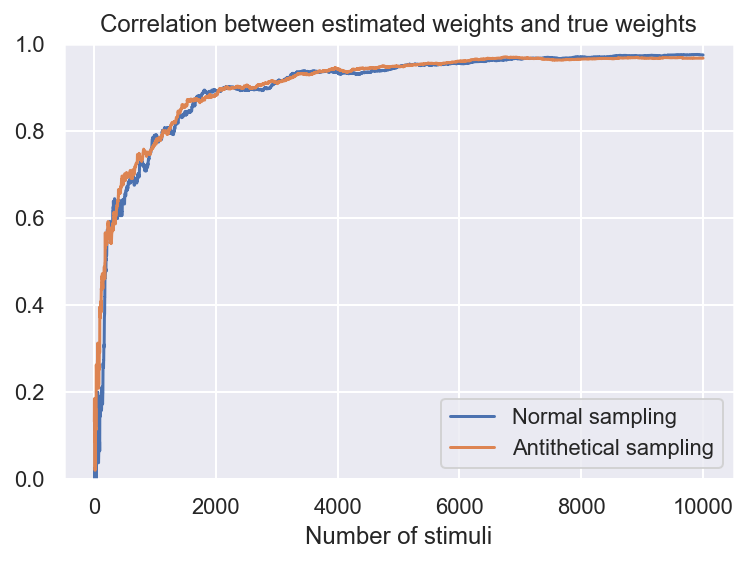

In [8]:
plt.plot(np.arange(1, N+1), rho)
plt.plot(np.arange(1, N+1), rho_p)
plt.legend(("Normal sampling", "Antithetical sampling"))
plt.xlabel("Number of stimuli")
plt.ylim((0, 1))
plt.title("Correlation between estimated weights and true weights")

Antithetical sampling does help a bit in this particular case. Let's repeat the experiment to determine if this is the 
case more generally.

In [9]:
N = 4000
results = []
for i in range(100):
    X = np.random.randn(N, model.input_size)
    Y = model.forward(X)

    w_hat = estimate_w_hat(X, Y)
    rho = calculate_rho(w_hat, model.w)
    
    rg = np.floor(np.arange(N) / 2.0).astype(np.int)
    alternating_sign = 2 * ((np.arange(N) % 2) - .5)
    Xs = alternating_sign.reshape((-1, 1)) * X[rg, :]
    Y = model.forward(Xs)
    
    w_hat = estimate_w_hat(Xs, Y)
    rho_p = calculate_rho(w_hat, model.w)

    results += [{'run': i, 
                 'nstims': j + 1, 
                 'rho': rho[j], 
                 'sampling_type': 'normal'} for j in range(len(rho))]
    results += [{'run': i, 
                 'nstims': j + 1, 
                 'rho': rho_p[j], 
                 'sampling_type': 'antithetical'} for j in range(len(rho_p))]
    
df = pd.DataFrame(results)

/home/pmin/miniconda3/envs/brian-notebooks/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


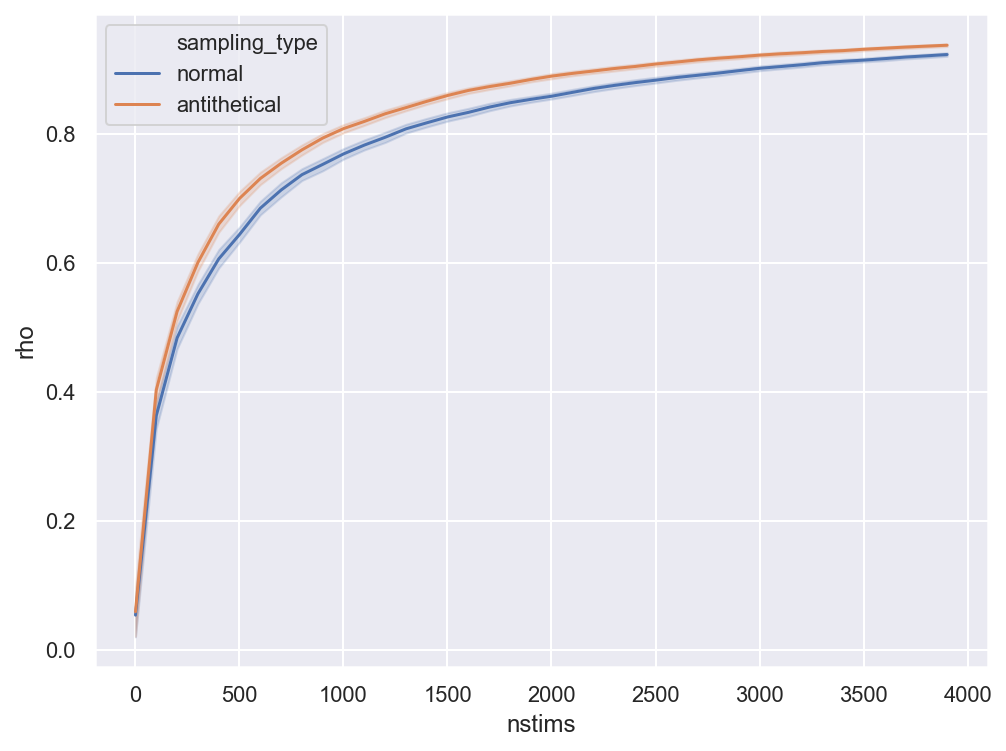

In [10]:
ax = plt.figure(figsize=(8, 6)).gca()
sns.lineplot(x='nstims', y='rho', hue='sampling_type', data=df[::100], ax=ax)

Antithetic sampling definitely helps! 

## The cake is a lie!

However, there's a better way of squeezing a bit more efficiency out of the reverse 
correlation estimate. 

Notice that since reverse correlation estimates the local gradient of the meab firing rate of a system, it should not change if the mean shifts. This is equivalent to saying that the derivative of a constant function is 0. However, if we set:

$y \to y + a$

Then the reverse correlation estimate shifts to:

$$\hat w = \frac{1}{N} X^T(y + a) = \frac{1}{N} X^T y + \frac{a}{N} X^T \hat 1$$

Now imagine that the y is centered around 0. As $a$ becomes larger and larger, the variance of $\hat w$ will grow. Let's show this in a simulation: 

In [11]:
results = []
X = np.random.randn(N, len(model.w))
y = model.forward(X)
# Center y for this demo.
y = y - y.mean()
for i in range(5):
    w_hat = estimate_w_hat(X, y + i * 2)
    rho = calculate_rho(w_hat, model.w)
    results += [{'nstims': j + 1, 
                 'rho': rho[j], 
                 'offset': str(i*2)} for j in range(len(rho))]

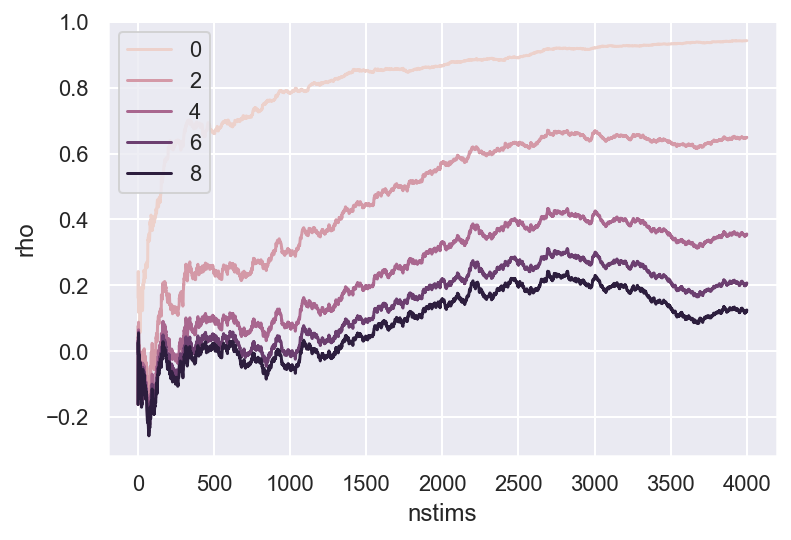

In [12]:
df = pd.DataFrame(results)
sns.lineplot(x='nstims', y='rho', hue='offset', data=df, ci=None)
plt.legend((0, 2, 4, 6, 8))

Adding an offset increases the variance of the estimates and thus it takes more stimuli for the reverse correlation estimate to converge to the true underlying parameter. One solution is antithetical sampling. With antithetical sampling, we have that $X^T \hat 1 = 0$, which reduces the variance of the estimate:

Text(0.5, 1.0, 'Estimate quality, antithetic sampling estimate')

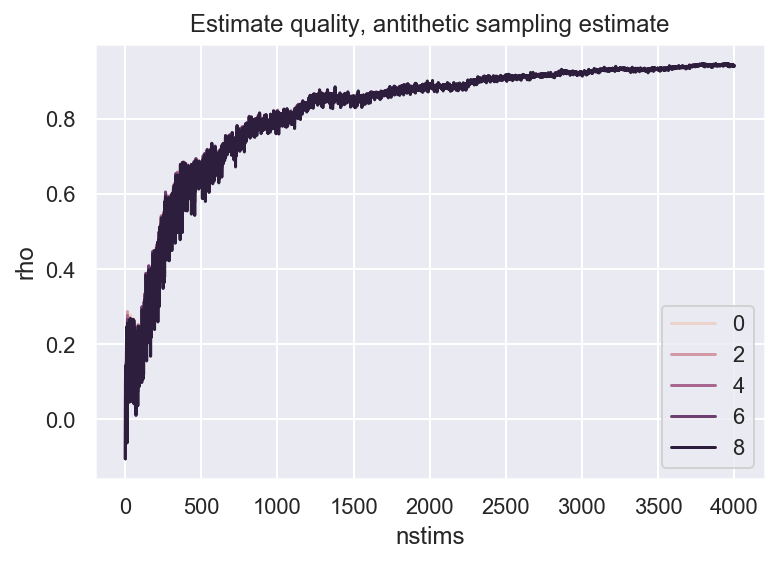

In [13]:
results = []
X = np.random.randn(N, len(model.w))

rg = np.floor(np.arange(N) / 2.0).astype(np.int)
alternating_sign = 2 * ((np.arange(N) % 2) - .5)
Xs = alternating_sign.reshape((-1, 1)) * X[rg, :]

y = model.forward(Xs)

# Center y for this demo.
y = y - y.mean()
for i in range(5):
    w_hat = estimate_w_hat(Xs, y + i * 2)
    rho = calculate_rho(w_hat, model.w)
    results += [{'nstims': j + 1, 
                 'rho': rho[j], 
                 'offset': str(i*2)} for j in range(len(rho))]

df = pd.DataFrame(results)
sns.lineplot(x='nstims', y='rho', hue='offset', data=df, ci=None)
plt.legend((0, 2, 4, 6, 8))
plt.title("Estimate quality, antithetic sampling estimate")

Indeed, this renders the estimates largely immune to the offset. However, there's another way of reducing the variance: choose $a$ such that $Var(\hat w)$ is minimized. Note, that the expectation of $X^T a$ is 0; however, it can nevertheless decrease the variance of the estimator. Indeed, we can show that the minimum variance estimate for $\hat w$ occurs when $a = \bar y$. 

This trick also pops up in other Monte Carlo estimates; see the [Control Variates section of this excellent blog post](http://blog.shakirm.com/2015/11/machine-learning-trick-of-the-day-5-log-derivative-trick/) for more references.    

In [14]:
def estimate_w_hat_low_var(X, Y):
    N = X.shape[0]
    # remove the mean.
    Ym = np.cumsum(Y)
    estimates = np.cumsum(X * (Y.reshape((-1, 1))), axis=0)
    mean = (Ym / np.arange(1, N + 1)).reshape((-1, 1)) * np.cumsum(X, axis=0)
    w_hat = 1 / np.arange(1, N + 1).reshape((-1, 1)) * (estimates - mean)
    return w_hat

results = []
X = np.random.randn(N, len(model.w))
y = model.forward(X)

for i in range(5):
    w_hat = estimate_w_hat_low_var(X, y + i * 2)
    rho = calculate_rho(w_hat, model.w)
    results += [{'nstims': j + 1, 
                 'rho': rho[j], 
                 'offset': str(i*2)} for j in range(len(rho))]

/home/pmin/miniconda3/envs/brian-notebooks/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Text(0.5, 1.0, 'Estimate quality, variance-stabilized estimate')

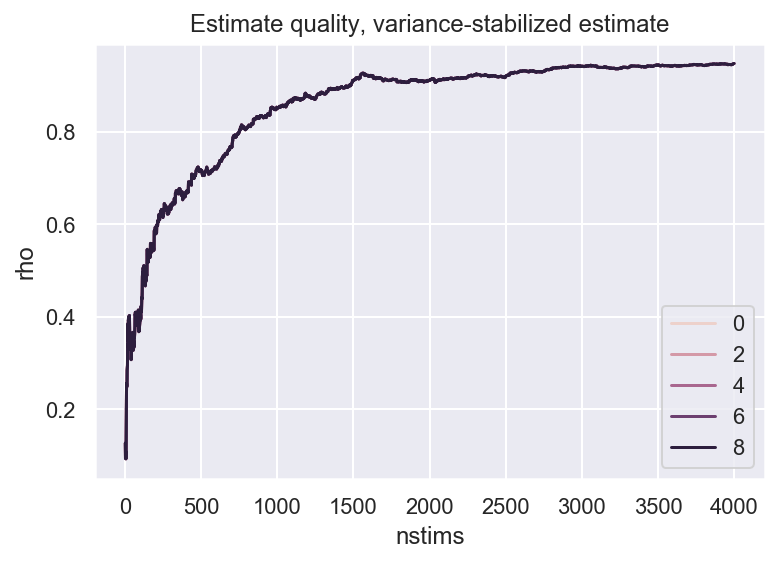

In [15]:
df = pd.DataFrame(results)
sns.lineplot(x='nstims', y='rho', hue='offset', data=df, ci=None)
plt.legend((0, 2, 4, 6, 8))
plt.title("Estimate quality, variance-stabilized estimate")

Which *trick* works best? For this scenario, it turns out that the variance-stabilized estimate works better than antithetic sampling:

In [16]:
N = 4000
results = []
for i in range(100):
    X = np.random.randn(N, model.input_size)
    Y = model.forward(X)

    w_hat = estimate_w_hat_low_var(X, Y)
    rho = calculate_rho(w_hat, model.w)
    
    rg = np.floor(np.arange(N) / 2.0).astype(np.int)
    alternating_sign = 2 * ((np.arange(N) % 2) - .5)
    Xs = alternating_sign.reshape((-1, 1)) * X[rg, :]
    Y = model.forward(Xs)
    
    w_hat = estimate_w_hat_low_var(Xs, Y)
    rho_p = calculate_rho(w_hat, model.w)

    results += [{'run': i, 
                 'nstims': j + 1, 
                 'rho': rho[j], 
                 'sampling_type': 'normal'} for j in range(len(rho))]
    results += [{'run': i, 
                 'nstims': j + 1, 
                 'rho': rho_p[j], 
                 'sampling_type': 'antithetical'} for j in range(len(rho_p))]
    
df = pd.DataFrame(results)

/home/pmin/miniconda3/envs/brian-notebooks/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


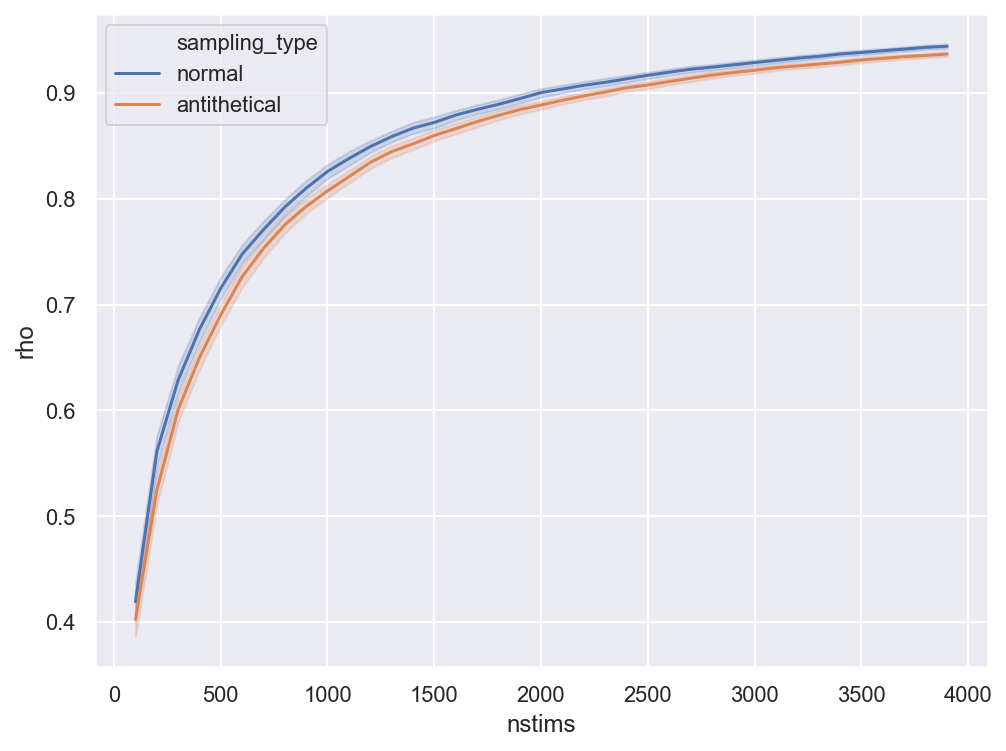

In [17]:
ax = plt.figure(figsize=(8, 6)).gca()
sns.lineplot(x='nstims', y='rho', hue='sampling_type', data=df[::100], ax=ax)



Conclusion: always you the variance-stabilized estimate by removing subtracting the mean response from $y$.